In [1]:
# --- Bloco 0: Importações ---
import pandas as pd
import numpy as np
import joblib # Para salvar os scalers

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Scikit-learn (para pré-processamento e métricas)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Optuna (para otimização de hiperparâmetros)
import optuna
import plotly.graph_objects as go
from optuna.trial import TrialState

# Outros
import math
import time
import matplotlib.pyplot as plt

# Configurações
plt.style.use('ggplot')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")
torch.manual_seed(42)

c:\Users\João Pedro Dandolini\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Usando dispositivo: cpu


In [2]:
# --- Bloco 1: Definição da Arquitetura da Rede (Dinâmica) ---
# Este bloco define *como* construir a rede,
# mas ela será instanciada dinamicamente pelo Optuna.

class Net(nn.Module):
    def __init__(self, n_layers, n_neurons):
        super(Net, self).__init__()
        
        layers = []
        
        # Camada de entrada (1 feature: Potencia_MW)
        layers.append(nn.Linear(1, n_neurons))
        layers.append(nn.ReLU())
        
        # Camadas ocultas dinâmicas
        for _ in range(n_layers - 1):
            layers.append(nn.Linear(n_neurons, n_neurons))
            layers.append(nn.ReLU())
            
        # Camada de saída (1 feature: Custo_Real)
        layers.append(nn.Linear(n_neurons, 1))
        
        # Compilar todas as camadas em um modelo sequencial
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

print("Definição da classe 'Net' concluída.")

Definição da classe 'Net' concluída.


In [3]:
# --- Bloco 2: Funções Auxiliares (Métricas e Complexidade) ---

def calculate_complexity(n_layers, n_neurons):
    """
    Calcula a métrica de complexidade customizada:
    log2(número de neurônios por camada) * número de camadas
    """
    if n_neurons == 0 or n_layers == 0:
        return 0
    return math.log2(n_neurons) * n_layers

def calculate_all_metrics(y_true, y_pred):
    """
    Calcula MSE, RMSE e MAPE.
    Espera arrays NumPy.
    """
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    return mse, rmse, mape

print("Funções auxiliares (calculate_complexity, calculate_all_metrics) prontas.")

Funções auxiliares (calculate_complexity, calculate_all_metrics) prontas.


In [4]:
# --- Bloco 3: Carregamento e Normalização dos Dados ---

# Carregar o dataset
df = pd.read_csv('usina_carvao_dataset.csv')

# Preparar dados para o scaler
X = df[['Potencia_MW']].values
y = df[['Custo_Real']].values

# Inicializar os scalers
# Usamos dois scalers separados para podermos
# salvar ambos e usá-los no notebook MILP.
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

# "Aprender" a escala dos dados e transformá-los
X_scaled = x_scaler.fit_transform(X)
y_scaled = y_scaler.fit_transform(y)

# Salvar os scalers para uso futuro!
joblib.dump(x_scaler, 'x_scaler.joblib')
joblib.dump(y_scaler, 'y_scaler.joblib')

print("Dados carregados e normalizados.")
print(f"Formato de X (Potência): {X_scaled.shape}")
print(f"Formato de y (Custo): {y_scaled.shape}")
print("\nScalers 'x_scaler.joblib' e 'y_scaler.joblib' salvos.")

Dados carregados e normalizados.
Formato de X (Potência): (5000, 1)
Formato de y (Custo): (5000, 1)

Scalers 'x_scaler.joblib' e 'y_scaler.joblib' salvos.


In [5]:
# --- Bloco 4: Separação Aleatória e DataLoaders ---
# Este bloco mistura os dados (shuffle=True) e os separa
# em conjuntos de treino e validação.

# Separar em treino (80%) e validação (20%)
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42
)

# Converter dados NumPy para Tensores do PyTorch
X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train, dtype=torch.float32).to(device)
X_val_t = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_t = torch.tensor(y_val, dtype=torch.float32).to(device)

# Criar DataLoaders para treinamento em lote (batch)
BATCH_SIZE = 64

train_dataset = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = TensorDataset(X_val_t, y_val_t)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Dados separados: {len(X_train_t)} amostras de treino, {len(X_val_t)} amostras de validação.")

Dados separados: 4000 amostras de treino, 1000 amostras de validação.


In [13]:
# --- Bloco 5: Definição da Função 'objective' do Optuna ---
# Este é o coração do notebook. Esta função será chamada
# dezenas de vezes pelo Optuna.

# Parâmetros do Treinamento
N_EPOCHS = 300       # Número de épocas que você definiu
EARLY_STOPPING_PATIENCE = 30 # Paciência que você pediu

def objective(trial):
    # --- 1. Sugerir Hiperparâmetros ---
    # Número de camadas (1 a 3)
    n_layers = trial.suggest_int('n_layers', 1, 1)
    # Número de neurônios (3 a 20)
    n_neurons = trial.suggest_int('n_neurons', 3, 50)
    # Taxa de aprendizado
    lr = trial.suggest_float('lr', 1e-4, 1e-1, log=True)
    
    # --- 2. Calcular Complexidade e Armazenar ---
    complexity = calculate_complexity(n_layers, n_neurons)
    trial.set_user_attr('complexity', complexity)

    # --- 3. Construir Modelo e Otimizador ---
    model = Net(n_layers, n_neurons).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss() # Usamos MSE para o loss

    # --- 4. Loop de Treinamento com Early Stopping & Pruning ---
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(N_EPOCHS):
        # Treinamento
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
        
        # Validação
        model.eval()
        current_val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                current_val_loss += loss.item() * X_batch.size(0)
        
        current_val_loss /= len(val_loader.dataset)
        
        # --- 5. Lógica de Pruning (pelo Optuna) ---
        trial.report(current_val_loss, epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()

        # --- 6. Lógica de Early Stopping ---
        if current_val_loss < best_val_loss:
            best_val_loss = current_val_loss
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= EARLY_STOPPING_PATIENCE:
            # print(f"Trial {trial.number} parou cedo no epoch {epoch}")
            break
            
    # --- 7. Retornar Métrica de Qualidade (RMSE) ---
    # Optuna minimiza o valor retornado.
    # Usamos o RMSE (raiz do MSE) como métrica de seleção.
    final_rmse = math.sqrt(best_val_loss)
    trial.set_user_attr('val_rmse', final_rmse)
    
    return final_rmse

print("Função 'objective' do Optuna definida.")

Função 'objective' do Optuna definida.


In [14]:
# --- Bloco 6: Execução do Estudo Optuna ---

print("--- Iniciando Estudo Optuna ---")
# Habilitar o Pruner (Poda) para cortar trials ruins
pruner = optuna.pruners.MedianPruner(n_warmup_steps=10)

study = optuna.create_study(direction='minimize', pruner=pruner)
study.optimize(objective, n_trials=50, show_progress_bar=True)

print("\n--- Estudo Optuna Concluído ---")
print(f"Melhor trial: {study.best_trial.number}")
print(f"  Melhor RMSE de Validação: {study.best_value:.6f}")
print("  Melhores Hiperparâmetros:")
for key, value in study.best_params.items():
    print(f"    {key}: {value}")
    
complexity = study.best_trial.user_attrs['complexity']
print(f"  Complexidade do Melhor Modelo: {complexity:.2f}")

[I 2025-10-27 21:04:01,091] A new study created in memory with name: no-name-d8f06efb-5c62-42a1-9b8d-d04393ff3fa1


--- Iniciando Estudo Optuna ---


Best trial: 0. Best value: 0.00591482:   2%|▏         | 1/50 [00:20<16:35, 20.32s/it]

[I 2025-10-27 21:04:21,415] Trial 0 finished with value: 0.005914820013017844 and parameters: {'n_layers': 1, 'n_neurons': 10, 'lr': 0.00013365844012615724}. Best is trial 0 with value: 0.005914820013017844.


Best trial: 1. Best value: 0.000725743:   4%|▍         | 2/50 [00:42<16:55, 21.15s/it]

[I 2025-10-27 21:04:43,138] Trial 1 finished with value: 0.0007257433919753773 and parameters: {'n_layers': 1, 'n_neurons': 36, 'lr': 0.005251562945928251}. Best is trial 1 with value: 0.0007257433919753773.


Best trial: 1. Best value: 0.000725743:   6%|▌         | 3/50 [00:46<10:29, 13.40s/it]

[I 2025-10-27 21:04:47,316] Trial 2 finished with value: 0.005677398510402982 and parameters: {'n_layers': 1, 'n_neurons': 4, 'lr': 0.06512211605285706}. Best is trial 1 with value: 0.0007257433919753773.


Best trial: 1. Best value: 0.000725743:   8%|▊         | 4/50 [01:09<13:17, 17.33s/it]

[I 2025-10-27 21:05:10,670] Trial 3 finished with value: 0.0017606678789982482 and parameters: {'n_layers': 1, 'n_neurons': 29, 'lr': 0.00011808246701405819}. Best is trial 1 with value: 0.0007257433919753773.


Best trial: 1. Best value: 0.000725743:  10%|█         | 5/50 [01:26<12:52, 17.16s/it]

[I 2025-10-27 21:05:27,527] Trial 4 finished with value: 0.0025801690887137735 and parameters: {'n_layers': 1, 'n_neurons': 30, 'lr': 0.0006577039740519089}. Best is trial 1 with value: 0.0007257433919753773.


Best trial: 1. Best value: 0.000725743:  12%|█▏        | 6/50 [01:27<08:32, 11.65s/it]

[I 2025-10-27 21:05:28,473] Trial 5 pruned. 


Best trial: 1. Best value: 0.000725743:  14%|█▍        | 7/50 [01:28<05:50,  8.15s/it]

[I 2025-10-27 21:05:29,411] Trial 6 pruned. 


Best trial: 1. Best value: 0.000725743:  16%|█▌        | 8/50 [01:32<04:51,  6.95s/it]

[I 2025-10-27 21:05:33,798] Trial 7 finished with value: 0.002632659989504831 and parameters: {'n_layers': 1, 'n_neurons': 20, 'lr': 0.07936499717064871}. Best is trial 1 with value: 0.0007257433919753773.


Best trial: 1. Best value: 0.000725743:  18%|█▊        | 9/50 [01:33<03:27,  5.05s/it]

[I 2025-10-27 21:05:34,669] Trial 8 pruned. 


Best trial: 1. Best value: 0.000725743:  20%|██        | 10/50 [01:57<07:10, 10.75s/it]

[I 2025-10-27 21:05:58,197] Trial 9 finished with value: 0.0009445239786344964 and parameters: {'n_layers': 1, 'n_neurons': 31, 'lr': 0.001935763794115732}. Best is trial 1 with value: 0.0007257433919753773.


Best trial: 10. Best value: 0.000692602:  22%|██▏       | 11/50 [02:05<06:35, 10.14s/it]

[I 2025-10-27 21:06:06,948] Trial 10 finished with value: 0.0006926016539867464 and parameters: {'n_layers': 1, 'n_neurons': 47, 'lr': 0.012734315872519286}. Best is trial 10 with value: 0.0006926016539867464.


Best trial: 10. Best value: 0.000692602:  24%|██▍       | 12/50 [02:21<07:28, 11.81s/it]

[I 2025-10-27 21:06:22,582] Trial 11 finished with value: 0.0007010551973108526 and parameters: {'n_layers': 1, 'n_neurons': 47, 'lr': 0.011097723854364397}. Best is trial 10 with value: 0.0006926016539867464.


Best trial: 10. Best value: 0.000692602:  26%|██▌       | 13/50 [02:28<06:19, 10.27s/it]

[I 2025-10-27 21:06:29,292] Trial 12 finished with value: 0.0011386995662317218 and parameters: {'n_layers': 1, 'n_neurons': 50, 'lr': 0.0139268028515362}. Best is trial 10 with value: 0.0006926016539867464.


Best trial: 10. Best value: 0.000692602:  28%|██▊       | 14/50 [02:41<06:46, 11.28s/it]

[I 2025-10-27 21:06:42,911] Trial 13 finished with value: 0.0009050711569025656 and parameters: {'n_layers': 1, 'n_neurons': 50, 'lr': 0.013099144758839365}. Best is trial 10 with value: 0.0006926016539867464.


Best trial: 10. Best value: 0.000692602:  30%|███       | 15/50 [02:48<05:42,  9.80s/it]

[I 2025-10-27 21:06:49,268] Trial 14 finished with value: 0.000988121402082708 and parameters: {'n_layers': 1, 'n_neurons': 39, 'lr': 0.014125507479525313}. Best is trial 10 with value: 0.0006926016539867464.


Best trial: 10. Best value: 0.000692602:  32%|███▏      | 16/50 [02:52<04:40,  8.25s/it]

[I 2025-10-27 21:06:53,927] Trial 15 finished with value: 0.0012598204001600642 and parameters: {'n_layers': 1, 'n_neurons': 43, 'lr': 0.03904294260579188}. Best is trial 10 with value: 0.0006926016539867464.


Best trial: 10. Best value: 0.000692602:  34%|███▍      | 17/50 [02:53<03:19,  6.04s/it]

[I 2025-10-27 21:06:54,818] Trial 16 pruned. 


Best trial: 10. Best value: 0.000692602:  36%|███▌      | 18/50 [02:59<03:12,  6.03s/it]

[I 2025-10-27 21:07:00,817] Trial 17 finished with value: 0.0012767872590708602 and parameters: {'n_layers': 1, 'n_neurons': 23, 'lr': 0.033182047485600594}. Best is trial 10 with value: 0.0006926016539867464.


Best trial: 10. Best value: 0.000692602:  38%|███▊      | 19/50 [03:00<02:18,  4.48s/it]

[I 2025-10-27 21:07:01,698] Trial 18 pruned. 


Best trial: 19. Best value: 0.000403676:  40%|████      | 20/50 [03:15<03:48,  7.61s/it]

[I 2025-10-27 21:07:16,604] Trial 19 finished with value: 0.0004036758799828455 and parameters: {'n_layers': 1, 'n_neurons': 37, 'lr': 0.026492546736443214}. Best is trial 19 with value: 0.0004036758799828455.


Best trial: 19. Best value: 0.000403676:  42%|████▏     | 21/50 [03:24<03:48,  7.87s/it]

[I 2025-10-27 21:07:25,091] Trial 20 finished with value: 0.0005644697800937712 and parameters: {'n_layers': 1, 'n_neurons': 39, 'lr': 0.029210209637073034}. Best is trial 19 with value: 0.0004036758799828455.


Best trial: 19. Best value: 0.000403676:  44%|████▍     | 22/50 [03:28<03:13,  6.90s/it]

[I 2025-10-27 21:07:29,725] Trial 21 finished with value: 0.0015492509440800007 and parameters: {'n_layers': 1, 'n_neurons': 36, 'lr': 0.025681913823066404}. Best is trial 19 with value: 0.0004036758799828455.


Best trial: 19. Best value: 0.000403676:  46%|████▌     | 23/50 [03:35<03:02,  6.78s/it]

[I 2025-10-27 21:07:36,208] Trial 22 finished with value: 0.0005328035681291038 and parameters: {'n_layers': 1, 'n_neurons': 39, 'lr': 0.024182024875394514}. Best is trial 19 with value: 0.0004036758799828455.


Best trial: 19. Best value: 0.000403676:  48%|████▊     | 24/50 [03:42<02:57,  6.84s/it]

[I 2025-10-27 21:07:43,200] Trial 23 finished with value: 0.0009139940527920305 and parameters: {'n_layers': 1, 'n_neurons': 39, 'lr': 0.049509911307693645}. Best is trial 19 with value: 0.0004036758799828455.


Best trial: 19. Best value: 0.000403676:  50%|█████     | 25/50 [03:42<02:06,  5.05s/it]

[I 2025-10-27 21:07:44,090] Trial 24 pruned. 


Best trial: 19. Best value: 0.000403676:  52%|█████▏    | 26/50 [03:43<01:31,  3.81s/it]

[I 2025-10-27 21:07:45,006] Trial 25 pruned. 


Best trial: 19. Best value: 0.000403676:  54%|█████▍    | 27/50 [03:52<02:00,  5.25s/it]

[I 2025-10-27 21:07:53,619] Trial 26 finished with value: 0.0007576418991204753 and parameters: {'n_layers': 1, 'n_neurons': 39, 'lr': 0.021021883945824594}. Best is trial 19 with value: 0.0004036758799828455.


Best trial: 19. Best value: 0.000403676:  56%|█████▌    | 28/50 [04:07<03:02,  8.30s/it]

[I 2025-10-27 21:08:09,013] Trial 27 finished with value: 0.0007366918872417842 and parameters: {'n_layers': 1, 'n_neurons': 33, 'lr': 0.003299446364569232}. Best is trial 19 with value: 0.0004036758799828455.


Best trial: 19. Best value: 0.000403676:  58%|█████▊    | 29/50 [04:15<02:46,  7.93s/it]

[I 2025-10-27 21:08:16,106] Trial 28 finished with value: 0.0007507566098255374 and parameters: {'n_layers': 1, 'n_neurons': 41, 'lr': 0.04731262104379509}. Best is trial 19 with value: 0.0004036758799828455.


Best trial: 19. Best value: 0.000403676:  60%|██████    | 30/50 [04:15<01:56,  5.83s/it]

[I 2025-10-27 21:08:17,016] Trial 29 pruned. 


Best trial: 19. Best value: 0.000403676:  62%|██████▏   | 31/50 [04:16<01:22,  4.35s/it]

[I 2025-10-27 21:08:17,911] Trial 30 pruned. 


Best trial: 19. Best value: 0.000403676:  64%|██████▍   | 32/50 [04:22<01:23,  4.66s/it]

[I 2025-10-27 21:08:23,288] Trial 31 finished with value: 0.0006541713276915241 and parameters: {'n_layers': 1, 'n_neurons': 47, 'lr': 0.03118619940001957}. Best is trial 19 with value: 0.0004036758799828455.


Best trial: 19. Best value: 0.000403676:  66%|██████▌   | 33/50 [04:29<01:33,  5.50s/it]

[I 2025-10-27 21:08:30,758] Trial 32 finished with value: 0.0006020315988596737 and parameters: {'n_layers': 1, 'n_neurons': 36, 'lr': 0.03448993306727512}. Best is trial 19 with value: 0.0004036758799828455.


Best trial: 19. Best value: 0.000403676:  68%|██████▊   | 34/50 [04:30<01:05,  4.12s/it]

[I 2025-10-27 21:08:31,642] Trial 33 pruned. 


Best trial: 19. Best value: 0.000403676:  70%|███████   | 35/50 [04:31<00:47,  3.15s/it]

[I 2025-10-27 21:08:32,534] Trial 34 pruned. 


Best trial: 19. Best value: 0.000403676:  72%|███████▏  | 36/50 [04:32<00:34,  2.48s/it]

[I 2025-10-27 21:08:33,440] Trial 35 pruned. 


Best trial: 19. Best value: 0.000403676:  74%|███████▍  | 37/50 [04:33<00:25,  2.00s/it]

[I 2025-10-27 21:08:34,327] Trial 36 pruned. 


Best trial: 19. Best value: 0.000403676:  76%|███████▌  | 38/50 [04:39<00:38,  3.18s/it]

[I 2025-10-27 21:08:40,266] Trial 37 finished with value: 0.0009080852079515242 and parameters: {'n_layers': 1, 'n_neurons': 29, 'lr': 0.06373081488109936}. Best is trial 19 with value: 0.0004036758799828455.


Best trial: 19. Best value: 0.000403676:  78%|███████▊  | 39/50 [04:40<00:27,  2.49s/it]

[I 2025-10-27 21:08:41,153] Trial 38 pruned. 


Best trial: 19. Best value: 0.000403676:  80%|████████  | 40/50 [04:41<00:20,  2.08s/it]

[I 2025-10-27 21:08:42,277] Trial 39 pruned. 


Best trial: 19. Best value: 0.000403676:  82%|████████▏ | 41/50 [04:42<00:15,  1.72s/it]

[I 2025-10-27 21:08:43,152] Trial 40 pruned. 


Best trial: 19. Best value: 0.000403676:  84%|████████▍ | 42/50 [04:46<00:19,  2.40s/it]

[I 2025-10-27 21:08:47,126] Trial 41 finished with value: 0.0009631874586745392 and parameters: {'n_layers': 1, 'n_neurons': 46, 'lr': 0.031001563145176766}. Best is trial 19 with value: 0.0004036758799828455.


Best trial: 19. Best value: 0.000403676:  86%|████████▌ | 43/50 [04:46<00:13,  1.94s/it]

[I 2025-10-27 21:08:48,010] Trial 42 pruned. 


Best trial: 19. Best value: 0.000403676:  88%|████████▊ | 44/50 [04:47<00:09,  1.62s/it]

[I 2025-10-27 21:08:48,887] Trial 43 pruned. 


Best trial: 19. Best value: 0.000403676:  90%|█████████ | 45/50 [04:48<00:07,  1.40s/it]

[I 2025-10-27 21:08:49,783] Trial 44 pruned. 


Best trial: 19. Best value: 0.000403676:  92%|█████████▏| 46/50 [04:49<00:04,  1.25s/it]

[I 2025-10-27 21:08:50,666] Trial 45 pruned. 


Best trial: 19. Best value: 0.000403676:  94%|█████████▍| 47/50 [04:50<00:03,  1.14s/it]

[I 2025-10-27 21:08:51,569] Trial 46 pruned. 


Best trial: 19. Best value: 0.000403676:  96%|█████████▌| 48/50 [04:56<00:05,  2.55s/it]

[I 2025-10-27 21:08:57,410] Trial 47 finished with value: 0.0006094188078422266 and parameters: {'n_layers': 1, 'n_neurons': 41, 'lr': 0.026734078049912464}. Best is trial 19 with value: 0.0004036758799828455.


Best trial: 19. Best value: 0.000403676:  98%|█████████▊| 49/50 [04:57<00:02,  2.05s/it]

[I 2025-10-27 21:08:58,301] Trial 48 pruned. 


Best trial: 19. Best value: 0.000403676: 100%|██████████| 50/50 [05:02<00:00,  6.05s/it]

[I 2025-10-27 21:09:03,836] Trial 49 finished with value: 0.0006868311326467929 and parameters: {'n_layers': 1, 'n_neurons': 30, 'lr': 0.046379349217931576}. Best is trial 19 with value: 0.0004036758799828455.

--- Estudo Optuna Concluído ---
Melhor trial: 19
  Melhor RMSE de Validação: 0.000404
  Melhores Hiperparâmetros:
    n_layers: 1
    n_neurons: 37
    lr: 0.026492546736443214
  Complexidade do Melhor Modelo: 5.21


In [15]:
# --- Bloco 7: Gráficos Elaborados do Optuna ---

print("Gerando gráficos do Optuna...")

# Gráfico 1: Histórico de Otimização (RMSE vs. Trial)
fig1 = optuna.visualization.plot_optimization_history(study)
fig1.show()

# Gráfico 2: Importância dos Hiperparâmetros
fig2 = optuna.visualization.plot_param_importances(study)
fig2.show()

# Gráfico 3: Gráfico Customizado (Qualidade vs. Complexidade)
# Este é o gráfico que você pediu
trials = [t for t in study.trials if t.state == TrialState.COMPLETE]
complexities = [t.user_attrs['complexity'] for t in trials]
val_rmses = [t.value for t in trials]
trial_numbers = [t.number for t in trials]

fig3 = go.Figure(data=go.Scatter(
    x=complexities,
    y=val_rmses,
    mode='markers',
    text=[f'Trial: {n}<br>RMSE: {r:.4f}<br>Complex: {c:.2f}' 
          for n, r, c in zip(trial_numbers, val_rmses, complexities)],
    marker=dict(
        color=val_rmses,
        colorscale='Viridis',
        showscale=True,
        colorbar=dict(title='RMSE de Validação')
    )
))
fig3.update_layout(
    title='Trade-off: Qualidade (RMSE) vs. Complexidade do Modelo',
    xaxis_title='Complexidade (log2(neurônios) * camadas)',
    yaxis_title='RMSE de Validação (Normalizado)',
    hovermode='closest'
)
fig3.show()

Gerando gráficos do Optuna...


In [ ]:
# --- Bloco 8: Treinamento Final da Rede "Campeã" ---
# Agora, pegamos os melhores hiperparâmetros e treinamos
# um modelo final do zero, salvando o histórico de loss.

print("--- Treinando a Rede 'Campeã' Final ---")

#'''
best_params = study.best_params
BASE_N_LAYERS = best_params['n_layers']
BASE_N_NEURONS = best_params['n_neurons']
BASE_LR = best_params['lr']
#'''

# {'n_layers': 1, 'n_neurons': 37, 'lr': 0.026492546736443214}

'''
BASE_N_LAYERS = 1
BASE_N_NEURONS = 37
BASE_LR = 0.026492546736443214
N_EPOCHS = 10
#'''

'''
BASE_N_LAYERS = 2
BASE_N_NEURONS = 13
BASE_LR = 0.008164828229766462
N_EPOCHS = 10
#'''

# Parâmetros da rede
final_model = Net(
    n_layers=BASE_N_LAYERS,
    n_neurons=BASE_N_NEURONS
).to(device)
final_lr = BASE_LR


optimizer = optim.Adam(final_model.parameters(), lr=final_lr)
criterion = nn.MSELoss()

# Listas para salvar o histórico de loss
train_losses = []
val_losses = []

# Usar os mesmos parâmetros do Optuna
best_val_loss = float('inf')
patience_counter = 0

start_time = time.time()
for epoch in range(N_EPOCHS):
    # Treinamento
    final_model.train()
    current_train_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = final_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        current_train_loss += loss.item() * X_batch.size(0)
    
    train_losses.append(current_train_loss / len(train_loader.dataset))
    
    # Validação
    final_model.eval()
    current_val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = final_model(X_batch)
            loss = criterion(outputs, y_batch)
            current_val_loss += loss.item() * X_batch.size(0)
            
    current_val_loss /= len(val_loader.dataset)
    val_losses.append(current_val_loss)

    # Lógica de Early Stopping
    if current_val_loss < best_val_loss:
        best_val_loss = current_val_loss
        patience_counter = 0
        # Salvar o melhor modelo
        torch.save(final_model.state_dict(), 'zzzzz_10.pth')
    else:
        patience_counter += 1
    
    if patience_counter >= EARLY_STOPPING_PATIENCE:
        print(f"Treinamento final parou cedo no epoch {epoch+1}")
        break

    if (epoch + 1) % 50 == 0:
        print(f"Epoch [{epoch+1}/{N_EPOCHS}], Train Loss: {train_losses[-1]:.6f}, Val Loss: {val_losses[-1]:.6f}")

end_time = time.time()
print(f"Treinamento final concluído em {end_time - start_time:.2f}s")
print("Modelo 'zzzzz_10.pth' salvo.")

--- Treinando a Rede 'Campeã' Final ---
Epoch [50/300], Train Loss: 0.000041, Val Loss: 0.000006
Epoch [100/300], Train Loss: 0.000008, Val Loss: 0.000013
Treinamento final parou cedo no epoch 123
Treinamento final concluído em 9.76s
Modelo 'zzzzz_10.pth' salvo.


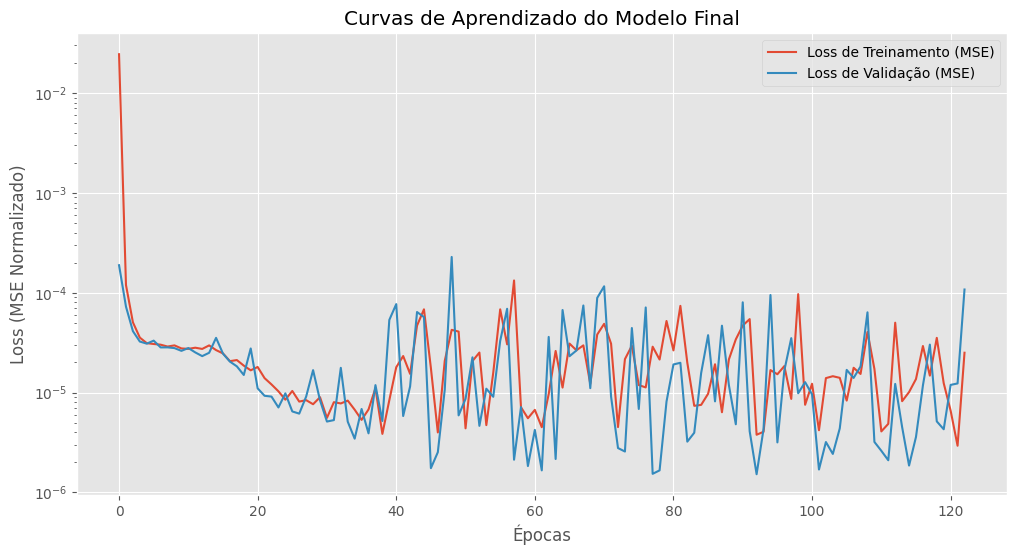

In [17]:
# --- Bloco 9: Gráfico de Treinamento (Loss vs. Epoch) ---

plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Loss de Treinamento (MSE)')
plt.plot(val_losses, label='Loss de Validação (MSE)')
plt.title('Curvas de Aprendizado do Modelo Final')
#plt.ylim(0,0.0005)
plt.xlabel('Épocas')
plt.ylabel('Loss (MSE Normalizado)')
plt.yscale('log') # Usar escala logarítmica é quase obrigatório aqui
plt.legend()
plt.show()

--- Avaliação Final do Modelo ---

Métricas Finais (em escala real de R$):
  MSE:  486.62
  RMSE: 22.06
  MAPE: 0.0029 %


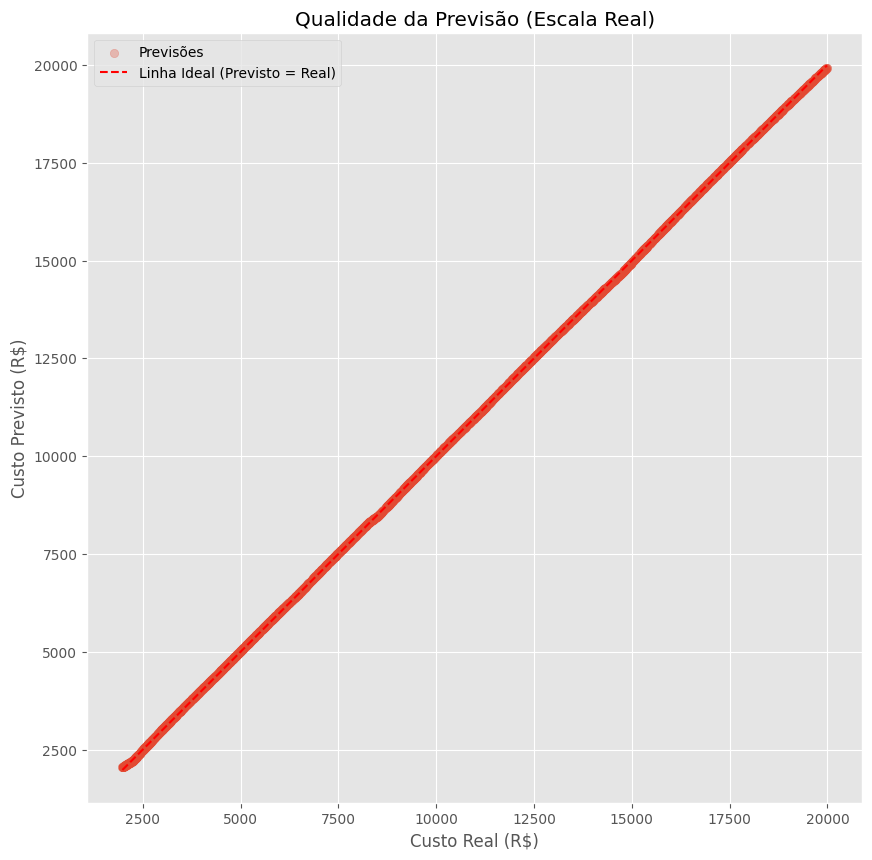

In [18]:
# --- Bloco 10: Avaliação Final (Métricas nos Dados Reais) ---

print("--- Avaliação Final do Modelo ---")

# Carregar o melhor modelo salvo
final_model.load_state_dict(torch.load('zzzzz_10.pth'))
final_model.eval()

# Passar TODOS os dados (X_scaled) pelo modelo
with torch.no_grad():
    y_pred_scaled_t = final_model(torch.tensor(X_scaled, dtype=torch.float32).to(device))

# Mover para CPU e converter para NumPy
y_pred_scaled = y_pred_scaled_t.cpu().numpy()

# --- IMPORTANTE: Reverter a Normalização ---
# Agora avaliamos na escala de R$ e MW reais
y_true_real = y_scaler.inverse_transform(y_scaled)
y_pred_real = y_scaler.inverse_transform(y_pred_scaled)
x_real = x_scaler.inverse_transform(X_scaled)

# Calcular métricas finais
mse, rmse, mape = calculate_all_metrics(y_true_real, y_pred_real)

print("\nMétricas Finais (em escala real de R$):")
print(f"  MSE:  {mse:,.2f}")
print(f"  RMSE: {rmse:,.2f}")
print(f"  MAPE: {mape:.4f} %")

# --- Gráfico Final: Real vs. Previsto ---
plt.figure(figsize=(10, 10))
plt.scatter(y_true_real, y_pred_real, alpha=0.3, label='Previsões')
# Adicionar a linha ideal (y=x)
ideal_line = np.linspace(min(y_true_real.min(), y_pred_real.min()), 
                         max(y_true_real.max(), y_pred_real.max()), 100)
plt.plot(ideal_line, ideal_line, 'r--', label='Linha Ideal (Previsto = Real)')

plt.title('Qualidade da Previsão (Escala Real)')
plt.xlabel('Custo Real (R$)')
plt.ylabel('Custo Previsto (R$)')
plt.legend()
plt.grid(True)
plt.axis('equal') # Forçar eixos iguais
plt.show()

In [19]:
# --- Bloco 5: Carregamento do Modelo Pré-Treinado ---

print("--- Iniciando Treinamento por Transferência ---")

# Re-criar a arquitetura EXATA do modelo base salvo
# (É crucial que os parâmetros sejam os mesmos)
MODEL_BASE_PATH = 'zzzzz_10.pth'

# Instanciar o novo modelo
transfer_model = Net(n_layers=BASE_N_LAYERS, n_neurons=BASE_N_NEURONS).to(device)

# --- A MÁGICA (Transfer Learning) ---
# Carregar os pesos (o "conhecimento") do modelo de 10 épocas
transfer_model.load_state_dict(torch.load(MODEL_BASE_PATH))
# ------------------------------------

print(f"Modelo pré-treinado '{MODEL_BASE_PATH}' carregado com sucesso.")

# Configurar o otimizador para o novo modelo
optimizer = optim.Adam(transfer_model.parameters(), lr=BASE_LR)
criterion = nn.MSELoss()

--- Iniciando Treinamento por Transferência ---
Modelo pré-treinado 'zzzzz_10.pth' carregado com sucesso.


In [ ]:
# --- Bloco 6: Continuação do Treinamento (Epoch 11 até o fim) ---

print("--- Continuando o treinamento (Epochs 11 a 300) ---")

# Parâmetros
N_TOTAL_EPOCHS = 300
N_EPOCHS_JA_TREINADAS = 10
EARLY_STOPPING_PATIENCE = 30 # A mesma paciência

# Listas para salvar o histórico de loss
train_losses = []
val_losses = []

best_val_loss = float('inf')
patience_counter = 0

start_time = time.time()
# Começamos o loop da época 11 até 300
for epoch in range(N_EPOCHS_JA_TREINADAS, N_TOTAL_EPOCHS):
    
    # Treinamento
    transfer_model.train()
    current_train_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = transfer_model(X_batch) # Usando o transfer_model
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        current_train_loss += loss.item() * X_batch.size(0)
    
    train_losses.append(current_train_loss / len(train_loader.dataset))
    
    # Validação
    transfer_model.eval()
    current_val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = transfer_model(X_batch) # Usando o transfer_model
            loss = criterion(outputs, y_batch)
            current_val_loss += loss.item() * X_batch.size(0)
            
    current_val_loss /= len(val_loader.dataset)
    val_losses.append(current_val_loss)

    # Lógica de Early Stopping
    if current_val_loss < best_val_loss:
        best_val_loss = current_val_loss
        patience_counter = 0
        # Salvar o melhor modelo
        torch.save(transfer_model.state_dict(), 'zzzzz_final.pth')
    else:
        patience_counter += 1
    
    if patience_counter >= EARLY_STOPPING_PATIENCE:
        print(f"Treinamento por transferência parou cedo no epoch {epoch+1}")
        break

    if (epoch + 1) % 50 == 0 or epoch == N_EPOCHS_JA_TREINADAS:
        # Imprime no primeiro loop (época 10) e a cada 50
        print(f"Epoch [{epoch+1}/{N_TOTAL_EPOCHS}], Train Loss: {train_losses[-1]:.6f}, Val Loss: {val_losses[-1]:.6f}")

end_time = time.time()
print(f"Treinamento por transferência concluído em {end_time - start_time:.2f}s")
print("Modelo 'zzzzz_final.pth' salvo.")

--- Continuando o treinamento (Epochs 11 a 300) ---
Epoch [11/300], Train Loss: 0.002352, Val Loss: 0.000034
Epoch [50/300], Train Loss: 0.000020, Val Loss: 0.000048
Epoch [100/300], Train Loss: 0.000001, Val Loss: 0.000006
Treinamento por transferência parou cedo no epoch 123
Treinamento por transferência concluído em 8.94s
Modelo 'transfer_model_final.pth' salvo.


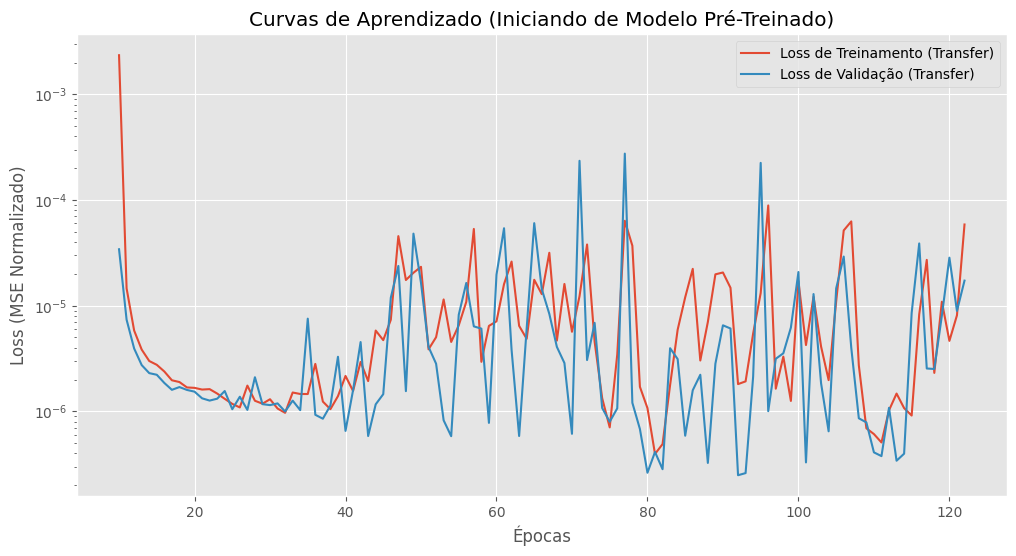

In [21]:
# --- Bloco 7: Gráfico de Treinamento (Loss vs. Epoch) ---
# Este gráfico será a prova: ele vai começar BAIXO.

plt.figure(figsize=(12, 6))
# Plotar o loss a partir da época 11
plt.plot(range(N_EPOCHS_JA_TREINADAS, N_EPOCHS_JA_TREINADAS + len(train_losses)), 
         train_losses, 
         label='Loss de Treinamento (Transfer)')
plt.plot(range(N_EPOCHS_JA_TREINADAS, N_EPOCHS_JA_TREINADAS + len(val_losses)), 
         val_losses, 
         label='Loss de Validação (Transfer)')

plt.title('Curvas de Aprendizado (Iniciando de Modelo Pré-Treinado)')
plt.xlabel('Épocas')
plt.ylabel('Loss (MSE Normalizado)')
plt.legend()
plt.yscale('log')
plt.show()

--- Avaliação Final do Modelo de Transferência ---

Métricas Finais (em escala real de R$):
  MSE:  81.07
  RMSE: 9.00
  MAPE: 0.0009 %


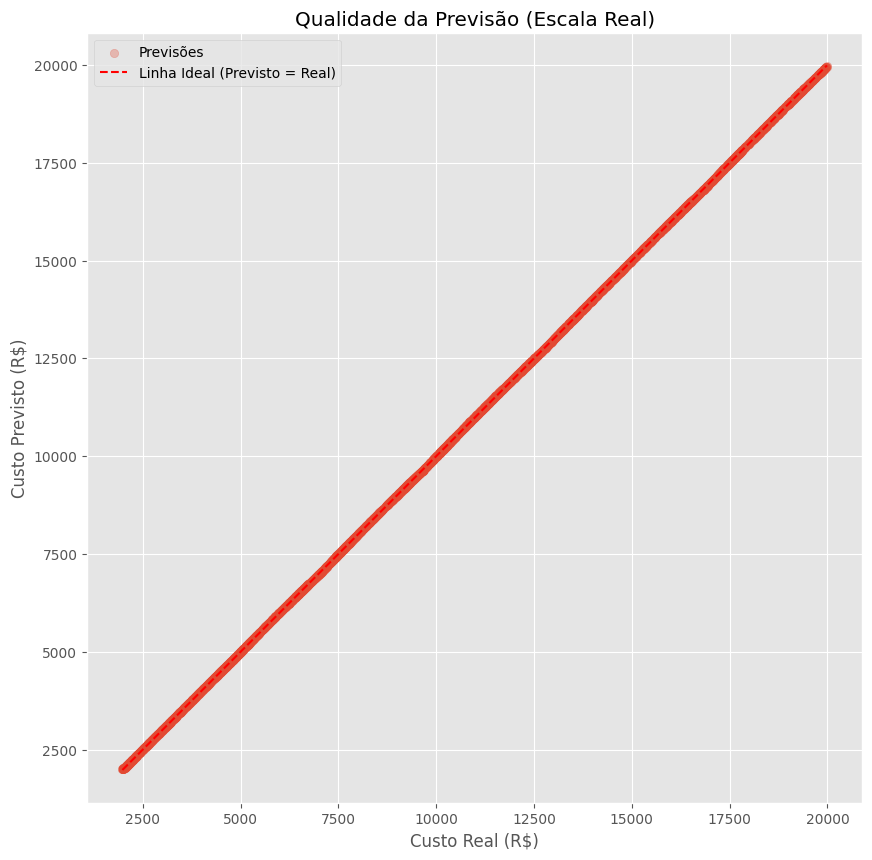

In [22]:
# --- Bloco 8: Avaliação Final (Métricas nos Dados Reais) ---
# Este bloco é idêntico ao Bloco 10 do notebook original,
# apenas carrega o 'transfer_model_final.pth'

print("--- Avaliação Final do Modelo de Transferência ---")

# Carregar os scalers
x_scaler = joblib.load('x_scaler.joblib')
y_scaler = joblib.load('y_scaler.joblib')

# Carregar os dados originais (não normalizados)
X = pd.read_csv('usina_carvao_dataset.csv')[['Potencia_MW']].values
y_true_real = pd.read_csv('usina_carvao_dataset.csv')[['Custo_Real']].values

# Carregar o melhor modelo salvo
eval_model = Net(n_layers=BASE_N_LAYERS, n_neurons=BASE_N_NEURONS).to(device)
eval_model.load_state_dict(torch.load('zzzzz_final.pth'))
eval_model.eval()

# Preparar dados de entrada (normalizar)
X_scaled = x_scaler.transform(X)

# Passar TODOS os dados pelo modelo
with torch.no_grad():
    y_pred_scaled_t = eval_model(torch.tensor(X_scaled, dtype=torch.float32).to(device))

# Mover para CPU e converter para NumPy
y_pred_scaled = y_pred_scaled_t.cpu().numpy()

# --- IMPORTANTE: Reverter a Normalização ---
y_pred_real = y_scaler.inverse_transform(y_pred_scaled)

# Calcular métricas finais
mse, rmse, mape = calculate_all_metrics(y_true_real, y_pred_real)

print("\nMétricas Finais (em escala real de R$):")
print(f"  MSE:  {mse:,.2f}")
print(f"  RMSE: {rmse:,.2f}")
print(f"  MAPE: {mape:.4f} %")

# --- Gráfico Final: Real vs. Previsto ---
plt.figure(figsize=(10, 10))
plt.scatter(y_true_real, y_pred_real, alpha=0.3, label='Previsões')
# Adicionar a linha ideal (y=x)
ideal_line = np.linspace(min(y_true_real.min(), y_pred_real.min()), 
                         max(y_true_real.max(), y_pred_real.max()), 100)
plt.plot(ideal_line, ideal_line, 'r--', label='Linha Ideal (Previsto = Real)')

plt.title('Qualidade da Previsão (Escala Real)')
plt.xlabel('Custo Real (R$)')
plt.ylabel('Custo Previsto (R$)')
plt.legend()
plt.grid(True)
plt.axis('equal') # Forçar eixos iguais
plt.show()

In [10]:
# --- Bloco 11: Visualizações Múltiplas do Modelo Final ("Campeão") ---
# Este bloco tenta gerar diagramas da arquitetura usando várias bibliotecas:
# torchviz, hiddenlayer, ONNX (para Netron), e torchview.

print("\n--- Gerando Visualizações Múltiplas da Rede 'Campeã' ---")

# --- 1. Verifica e importa as bibliotecas de visualização ---
libs_instaladas = True
try:
    from torchviz import make_dot
    import hiddenlayer as hl
    import torch.onnx
    from torchview import draw_graph
    print("Bibliotecas de visualização importadas com sucesso.")
except ImportError as e:
    libs_instaladas = False
    print(f"ERRO DE IMPORTAÇÃO: {e}")
    print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
    print("!! POR FAVOR, INSTALE AS BIBLIOTECAS NECESSÁRIAS:       !!")
    print("!! pip install torchviz hiddenlayer torchview onnx      !!")
    print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
    # Nota: torchviz e torchview podem precisar do software Graphviz instalado no sistema.

# --- 2. Só continua se as bibliotecas estiverem OK ---
if libs_instaladas:
    try:
        # --- Preparação: Carregar Modelo e Criar Input Falso ---

        # Verificar se as variáveis da arquitetura existem (do Bloco 8)
        if 'BASE_N_LAYERS' not in locals() or 'BASE_N_NEURONS' not in locals():
            raise NameError("Variáveis BASE_N_LAYERS/BASE_N_NEURONS não definidas. Execute o Bloco 8.")

        # Instanciar o modelo com a arquitetura correta
        viz_model = Net(n_layers=BASE_N_LAYERS, n_neurons=BASE_N_NEURONS).to(device)

        # Nome do arquivo do modelo salvo no Bloco 8
        SAVED_MODEL_FILENAME = 'zzzzz_final.pth' # CONFIRME ESTE NOME

        # Carregar os pesos do modelo campeão
        viz_model.load_state_dict(torch.load(SAVED_MODEL_FILENAME))
        viz_model.eval() # Colocar em modo de avaliação

        # Criar um dado de entrada falso (dummy input)
        # Nosso modelo espera shape [batch_size, 1]
        dummy_input = torch.randn(1, 1, requires_grad=True).to(device) # batch_size=1
        dummy_inputs = (dummy_input,) # Precisa ser tupla para algumas bibliotecas

        print(f"Modelo '{SAVED_MODEL_FILENAME}' carregado.")
        print(f"Input de exemplo criado: shape={dummy_input.shape}")

        # --- Opção 3: ONNX (Exportação para visualizador externo como Netron) ---
        try:
            input_names = ['Potencia_MW'] # Nome do nosso único input
            output_names = ['Custo_Previsto'] # Nome da nossa única saída
            output_filename_onnx = 'modelo_Linear.onnx'
            
            torch.onnx.export(viz_model, 
                              dummy_inputs, 
                              output_filename_onnx, 
                              input_names=input_names, 
                              output_names=output_names,
                              opset_version=11) # Versão comum do ONNX
            print(f"[OK] Modelo '{output_filename_onnx}' salvo (via ONNX). (Visualize online em netron.app)")
        except Exception as e:
            print(f"[FALHA ONNX]: {e}")

        # --- Opção 4: torchview (Gráfico de Arquitetura com Shapes) ---
        try:
            output_filename_tvw = 'modelo_torchview'
            # input_data pode ser a tupla
            model_graph = draw_graph(viz_model, 
                                     input_data=dummy_inputs, 
                                     expand_nested=True, # Mostrar detalhes dentro do nn.Sequential
                                     save_graph=True,
                                     filename=output_filename_tvw,
                                     graph_dir='.') # Salvar na pasta atual
            # model_graph.visual_graph.render(format='png') # Se save_graph=False
            print(f"[OK] Diagrama '{output_filename_tvw}.gv.png' salvo (via torchview).")
        except Exception as e:
            print(f"[FALHA torchview]: {e}. Verifique a instalação do Graphviz.")

    except NameError as e:
        print(f"ERRO: Variável não definida: {e}. Certifique-se de que as variáveis de arquitetura existem.")
    except FileNotFoundError:
         print(f"ERRO: Arquivo do modelo '{SAVED_MODEL_FILENAME}' não encontrado.")
         print("Verifique o nome do arquivo salvo no Bloco 8.")
    except Exception as e:
         print(f"ERRO inesperado na preparação da visualização: {e}")

    # Opcional: Colocar o modelo de volta no modo de treino se necessário depois
    # viz_model.train() 

else:
    print("\nVisualização pulada. Instale as bibliotecas e rode esta célula novamente.")


--- Gerando Visualizações Múltiplas da Rede 'Campeã' ---
Bibliotecas de visualização importadas com sucesso.
Modelo 'zzzzz_final.pth' carregado.
Input de exemplo criado: shape=torch.Size([1, 1])
[OK] Modelo 'modelo_Linear.onnx' salvo (via ONNX). (Visualize online em netron.app)
[FALHA torchview]: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH. Verifique a instalação do Graphviz.


C:\Users\João Pedro Dandolini\AppData\Local\Temp\ipykernel_17388\2459497087.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  viz_model.load_state_dict(torch.load(SAVED_M